In [1]:
# help function
from transfer_learning import NeuralNet
from dataset_loader import data_loader, all_filter, get_descriptors, one_filter, data_scaler

# modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import os, sys
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from tqdm import tqdm
from scipy.stats import pearsonr

import matplotlib.pyplot as plt 

# file name and data path
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_path = os.getcwd()
file_name = 'data/CrystGrowthDesign_SI.csv'

"""
Data description.

    Descriptors:
        'void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest'
    Source task:
        'H2@100 bar/243K (wt%)'
    Target tasks:
        'H2@100 bar/130K (wt%)' 'CH4@100 bar/298 K (mg/g)' '5 bar Xe mol/kg' '5 bar Kr mol/kg'
"""

descriptor_columns = ['void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest']
one_filter_columns = ['H2@100 bar/243K (wt%)'] 
another_filter_columns = ['H2@100 bar/130K (wt%)'] 

# load data
data = data_loader(base_path, file_name)
data=data.reset_index(drop=True)
# extract descriptors and gas adsorptions
one_property = one_filter(data, one_filter_columns)
descriptors = get_descriptors(data, descriptor_columns)

# prepare training inputs and outputs
X = np.array(descriptors.values, dtype=np.float32)
y = np.array(one_property.values, dtype=np.float32).reshape(len(X), )

X = data_scaler(X)
y = data_scaler(y.reshape(-1, 1)).reshape(len(X),)
epochs=1000
## hyper-parameters

seeds = np.arange(epochs)
Ns = list()
scores_epochs = list()
scores_test = list()
scores_train = list()

pred_tests = list()
grt_train_X = list()
grt_test_X = list()
grt_tests = list()
nsamples=100

input_size = 6
hidden_size_1 = 128
hidden_size_2 = 64
output_size = 1
learning_rate = .0002


model = NeuralNet(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

from Statistics_helper import stratified_cluster_sample
df,t_1,t_2,y_1,y_2=stratified_cluster_sample(1,data,descriptor_columns,one_filter_columns[0],5,net_out=True)
df=df[0]
#df=df.drop("Cluster",axis=1)
interest=one_filter_columns[0]
descriptor_columns.append("Cluster")
features=descriptor_columns
from transfer_learning import MyDataset
df_train,df_val,y_df_train,y_df_val = train_test_split(df[features],df[interest],test_size=.1)
df_train[interest]=np.array(y_df_train)
df_val[interest]=(np.array(y_df_val))
first=MyDataset(df_train,interest,features)
train_loader= torch.utils.data.DataLoader(first,batch_size=512)
second=MyDataset(df_val,interest,features)
val_loader = torch.utils.data.DataLoader(second,batch_size=len(df_val))



In [2]:
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, MeanSquaredError
from ignite.contrib.metrics.regression import R2Score
#declared model above
def train_step(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)

@trainer.on(Events.EPOCH_COMPLETED(every=1))
def log_training(engine):
    batch_loss = engine.state.output
    lr = optimizer.param_groups[0]['lr']
    e = engine.state.epoch
    n = engine.state.max_epochs
    i = engine.state.iteration
    print(f"Epoch {e}/{n} : {i} - batch loss: {batch_loss}, lr: {lr}")


trainer.run(train_loader, max_epochs=5)

Epoch 1/5 : 24 - batch loss: 35.89192199707031, lr: 0.0002
Epoch 2/5 : 48 - batch loss: 31.44891929626465, lr: 0.0002
Epoch 3/5 : 72 - batch loss: 26.02949333190918, lr: 0.0002
Epoch 4/5 : 96 - batch loss: 20.695016860961914, lr: 0.0002
Epoch 5/5 : 120 - batch loss: 15.849411964416504, lr: 0.0002


State:
	iteration: 120
	epoch: 5
	epoch_length: 24
	max_epochs: 5
	output: 15.849411964416504
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [3]:
import time
epochs=1000
batch_size=256
store_loss=[]
store_time=[]
start=time.time()
model = NeuralNet(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
trainer = Engine(train_step)
@trainer.on(Events.EPOCH_COMPLETED(every=1))
def log_training(engine):
    batch_loss = engine.state.output
    lr = optimizer.param_groups[0]['lr']
    e = engine.state.epoch
    n = engine.state.max_epochs
    i = engine.state.iteration
    print(f"Epoch {e}/{n} : {i} - batch loss: {batch_loss}, lr: {lr}")
train_loader= torch.utils.data.DataLoader(first,batch_size=i)
trainer.run(train_loader, max_epochs=epochs)
b=val_loader.dataset.y_train
a=val_loader.dataset.x_train
b=b.view(-1,1)
pred=model(a)
loss=criterion(pred,b)
end=time.time()
store_time.append(end-start)
store_loss.append(loss)


NameError: name 'i' is not defined

In [8]:
import time
from torchvision.transforms import Compose, Normalize, ToTensor
from ignite.engine import Events, create_supervised_evaluator, create_supervised_trainer
from ignite.handlers import Checkpoint
from ignite.metrics import Accuracy, Loss
from ignite.utils import setup_logger
from ignite.utils import setup_logger
from ignite.contrib.handlers.clearml_logger import (
    ClearMLLogger,
    ClearMLSaver,
    GradsHistHandler,
    GradsScalarHandler,
    WeightsHistHandler,
    WeightsScalarHandler,
    global_step_from_engine,
)

epochs=1000
batch_size=128
store_loss=[]
store_time=[]
start=time.time()
model = NeuralNet(input_size, hidden_size_1, hidden_size_2, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
trainer = Engine(train_step)
trainer.logger = setup_logger("Trainer")
@trainer.on(Events.EPOCH_COMPLETED(every=10))
def log_training(engine):
    batch_loss = engine.state.output
    lr = optimizer.param_groups[0]['lr']
    e = engine.state.epoch
    n = engine.state.max_epochs
    i = engine.state.iteration
    #print(f"Epoch {e}/{n} : {i} - batch loss: {batch_loss}, lr: {lr}")
metrics = {"loss": Loss(criterion)}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
train_evaluator.logger = setup_logger("Train Evaluator")
validation_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
validation_evaluator.logger = setup_logger("Val Evaluator")

@trainer.on(Events.EPOCH_COMPLETED)
def compute_metrics(engine):
    train_evaluator.run(train_loader)
    validation_evaluator.run(val_loader)

train_loader= torch.utils.data.DataLoader(first,batch_size=batch_size)
#trainer.run(train_loader, max_epochs=epochs)
clearml_logger = ClearMLLogger(project_name="examples", task_name="ignite") 

# Attach the logger to the trainer to log training loss 
clearml_logger.attach_output_handler(
    trainer,
    event_name=Events.ITERATION_COMPLETED(every=10),
    tag="training",
    output_transform=lambda loss: {"batchloss": loss},
)

# Attach the logger to log loss and accuracy for both training and validation
for tag, evaluator in [("training metrics", train_evaluator), ("validation metrics", validation_evaluator)]:
    clearml_logger.attach_output_handler(
        evaluator,
        event_name=Events.EPOCH_COMPLETED,
        tag=tag,
        metric_names=["loss"],
        global_step_transform=global_step_from_engine(trainer),
    )

# Attach the logger to the trainer to log optimizer's parameters, e.g. learning rate 
clearml_logger.attach_opt_params_handler(
    trainer, event_name=Events.ITERATION_COMPLETED(every=100), optimizer=optimizer
)

# Attach the logger to the trainer to log model's weights norm
clearml_logger.attach(
    trainer, log_handler=WeightsScalarHandler(model), event_name=Events.ITERATION_COMPLETED(every=100)
)

# Attach the logger to the trainer to log model's weights as a histogram 
clearml_logger.attach(trainer, log_handler=WeightsHistHandler(model), event_name=Events.EPOCH_COMPLETED(every=100))

# Attach the logger to the trainer to log model’s gradients as scalars
clearml_logger.attach(
    trainer, log_handler=GradsScalarHandler(model), event_name=Events.ITERATION_COMPLETED(every=100)
)

#Attach the logger to the trainer to log model's gradients as a histogram    
clearml_logger.attach(trainer, log_handler=GradsHistHandler(model), event_name=Events.EPOCH_COMPLETED(every=100))

handler = Checkpoint(
    {"model": model},
    ClearMLSaver(),
    n_saved=1,
    score_function=lambda e: e.state.metrics["loss"],
    filename_prefix="best",
    global_step_transform=global_step_from_engine(trainer),
)
validation_evaluator.add_event_handler(Events.EPOCH_COMPLETED, handler)

trainer.run(train_loader, max_epochs=epochs)

clearml_logger.close()

"""
b=val_loader.dataset.y_train
a=val_loader.dataset.x_train
b=b.view(-1,1)
pred=model(a)
loss=criterion(pred,b)
end=time.time()
store_time.append(end-start)
store_loss.append(loss)
"""

2022-03-16 12:46:04,152 Trainer INFO: Engine run starting with max_epochs=1000.
2022-03-16 12:46:04,415 Train Evaluator INFO: Engine run starting with max_epochs=1.
2022-03-16 12:46:04,533 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:00
2022-03-16 12:46:04,534 Train Evaluator INFO: Engine run complete. Time taken: 00:00:00
2022-03-16 12:46:04,534 Val Evaluator INFO: Engine run starting with max_epochs=1.
2022-03-16 12:46:04,547 Val Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:00
2022-03-16 12:46:04,547 Val Evaluator INFO: Engine run complete. Time taken: 00:00:00
2022-03-16 12:46:04,548 Trainer INFO: Epoch[1] Complete. Time taken: 00:00:00
2022-03-16 12:46:04,750 Train Evaluator INFO: Engine run starting with max_epochs=1.
2022-03-16 12:46:04,855 Train Evaluator INFO: Epoch[1] Complete. Time taken: 00:00:00
2022-03-16 12:46:04,856 Train Evaluator INFO: Engine run complete. Time taken: 00:00:00
2022-03-16 12:46:04,856 Val Evaluator INFO: Engine run starting with ma

'\nb=val_loader.dataset.y_train\na=val_loader.dataset.x_train\nb=b.view(-1,1)\npred=model(a)\nloss=criterion(pred,b)\nend=time.time()\nstore_time.append(end-start)\nstore_loss.append(loss)\n'

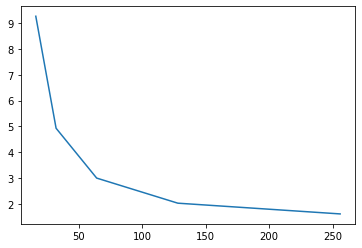

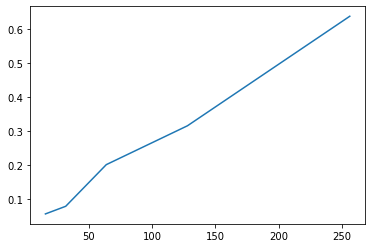

In [32]:
store_loss=[float(a) for a in store_loss]
plt.plot(test_set,store_time)
plt.show()
plt.plot(test_set,store_loss)

0
0.0123786
tensor(0.0124, grad_fn=<MseLossBackward0>)
0.9990428856149671


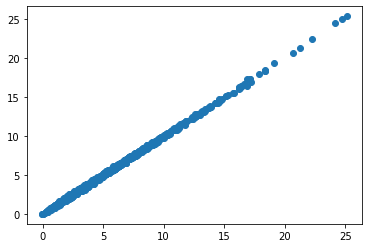

In [7]:
from sklearn.metrics import r2_score,mean_squared_error
start=0
for a,b in val_loader:
    out=model(a)
    print(start)
print(mean_squared_error(out.detach(),b))
b = b.view(-1,1)
print(criterion(out,b))
print(r2_score(out.detach().numpy(),b))
plt.scatter(out.detach().numpy(),b)